In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

In [ ]:
a_fns = ['sigmoid','tanh','relu','leakyRelu','linear','softmax']
wts = ['zero', 'random', 'normal']

In [ ]:
class NeuralNetwork():
  def __init__(self,n,layer_size,lr,activ_func,weight,batch_size,epochs):
        self.layer_size=layer_size[1:]
        self.n=len(self.layer_size)
        self.lr=lr
        self.activ_func=activ_func
        self.weight=weight
        self.batch_size=batch_size
        self.epochs=epochs
        self.weights={}
        self.frwd_dict = {}
        self.derivatives = {}
        self.num_samples=0
        self.tr_losses=[]
        self.val_losses=[]
        self.tr_accuracy=[]
        self.val_accuracy=[]

        if weight not in wts:
            raise Exception('Weight initialization function is wrong')
        if activ_func not in a_fns:
            raise Exception('Incorrect activation function is wrong')


  def sigmoid(self,x):
    print(np.exp(-x).shape)
    ans = 1.0/(1.0+np.exp(-x))
    print("ans.shape",ans.shape)
    der = ans*(1-ans)
    return ans,der

  def tanh(self,x):
      ans = np.tanh(x)
      der = 1-np.power(ans,2)
      return ans,der

  def relu(self,x):
      ans = np.maximum(0,x)
      print(x.shape)
      print(np.array(x).shape)
      der = np.greater(x, 0.).astype(np.float32)
      return ans,der

  def leakyRelu(self,x):
      ans = np.maximum(x,0.001*x)
      r = x.shape[0]  
      c = x.shape[1]
      der = np.ones_like(x)
      der[x < 0] = 0.001
      # der = np.ones(x,(r,c))
      # der[x<0]=0.001
      return ans,der
    
  def linear(self,x):
      der = np.ones_like(x)
      return x,der
    
  def softmax(self,x):
    max = np.max(x)
    x_dash=np.exp(x-max)
    ans = x_dash/np.sum(x_dash,axis=1,keepdims=True)
    a = np.eye(ans.shape[-1])
    temp1 = np.zeros((ans.shape[0], ans.shape[1], ans.shape[1]),dtype=np.float32)
    temp2 = np.zeros((ans.shape[0], ans.shape[1], ans.shape[1]),dtype=np.float32)
    temp1 = np.einsum('ij,jk->ijk',ans,a)
    temp2 = np.einsum('ij,ik->ijk',ans,ans)
    der = temp1 - temp2
    #re = x.reshape(-1,1)
    #der= np.diagflat(x)-np.dot(re,np.transpose(re))
    return ans,der

  def zero_weight(self,x,y):
     ans=np.zeros((x,y))
     return ans

  def random_weight(self,x,y):
    ans = np.random.randn(x,y)*0.01
    return ans

  def normal_weight(self,x,y):
    s = (x,y)
    ans = np.random.normal(size=s,scale=0.01)
    return ans

  def init_AF(self,x):
    ans,der = 0,0
    if self.activ_func =='sigmoid':
      ans,der = self.sigmoid(x) 
    elif self.activ_func =='tanh':
      ans,der = self.tanh(x)
    elif self.activ_func =='relu':
      ans,der = self.relu(x)
    elif self.activ_func =='leakyRelu':
      ans,der = self.leakyRelu(x)
    elif self.activ_func =='linear':
      ans,der = self.linear(x)
    elif self.activ_func =='softmax':
      ans,der = self.softmax(x) 
    return ans,der
      
  def init_weight(self):
    print("n " ,self.n)
    for i in range(0,self.n):
      wt=0
      bias=0
      if self.weight == 'zero':
        wt = self.zero_weight(self.layer_size[i+1],self.layer_size[i])
        bias = np.zeros(self.layer_size[i+1],1)

      elif self.weight == 'random':
        wt = self.random_weight(self.layer_size[i+1],self.layer_size[i])
        bias = np.zeros(self.layer_size[i+1],1)

      elif self.weight == "normal":
        print("i", i)
        # print("self.layer_size[i]",self.layer_size[i])
        # print("self.layer_size[i+1]",self.layer_size[i+1])
        wt = self.normal_weight(self.layer_size[i+1],self.layer_size[i])
        print("wt" ,wt.shape)
        bias = np.zeros((self.layer_size[i+1],1),dtype=float)
        print("bias" ,bias.shape)

      self.weights["w"+str(i+1)] = wt
      self.weights["b"+str(i+1)] = bias
  
  def forward(self,x):
    new_af = x
    print("x - ",x.shape)
    print("****")
    print("n-1",self.n-1)
    i=0
    for i in range(self.n-1):
      print("i - ",i)
      if(i>=1):
        old_af = new_af[i-1]
      else:
        old_af = new_af
      print("wts :",self.weights["w"+str(i+1)].shape)
      print("old_Af :", old_af.shape)
      print("bias :",self.weights["b"+str(i+1)].shape)
      # if(self.weights["w"+str(i+1)].shape[1]!=old_af.shape[0] and
      #    self.weights["w"+str(i+1)].shape[0]!=old_af.shape[1]):
      #   input= np.dot(old_af,self.weights["w"+str(i+1)].T)
      # else:
      input= self.weights["w"+str(i+1)].dot(old_af)
      print("inp",input.shape)
      input = input +self.weights["b"+str(i+1)]
      print("inp",input.shape)
      new_af,der = self.init_AF(input.T)
      self.frwd_dict["i"+str(i+1)]=input
      self.frwd_dict["w"+str(i+1)]=self.weights["w"+str(i+1)]
      self.frwd_dict["o"+str(i+1)]=new_af[i]
      print("nafi",new_af[i].shape)
    print("last")
    print(i)
    print("wts :",self.weights["w"+str(self.n)].shape)
    print("new_Af :", new_af[i].shape)
    print("bias :",self.weights["b"+str(self.n)].shape)
    input= np.dot(self.weights["w"+str(self.n)],new_af[i])+self.weights["b"+str(self.n)]
    print("inp",input.shape)
    new_af,der=self.softmax(input)
    print("new_Af :", new_af.shape)
    self.frwd_dict["i"+str(self.n)]=input
    self.frwd_dict["w"+str(self.n)]=self.weights["w"+str(self.n)]
    self.frwd_dict["o"+str(self.n)]=new_af[0]
    print("naf-1",new_af[0].shape)
    #print("new_af", new_af[0].shape, new_af)
    
    return new_af

  def backward(self,x,y):
    L = self.n
    print(L)
    self.frwd_dict["o0"]=x
    print(self.frwd_dict["o0"].shape)
    output = self.frwd_dict["o"+str(self.n)]
    print(self.frwd_dict["o"+str(self.n)].shape)
    print(y.shape)
    in_delta = output-y
    #in_delta = np.square(in_delta)
    print(in_delta.shape)
    print(len(x))
    if(len(x)==self.batch_size): 
      print("yes true")
    np.reshape(self.frwd_dict["o"+str(self.n-1)],(1,32),order = 'C')
    np.reshape(in_delta,(1,10))
    #self.frwd_dict["o"+str(self.n-1)].reshape(1,32)
    self.frwd_dict["o"+str(self.n-1)] = self.frwd_dict["o"+str(self.n-1)].reshape(1, -1)
    print("****",self.frwd_dict["o"+str(self.n-1)].shape)
    in_delta = in_delta.reshape(1,-1)
    print(in_delta.T.shape)

    w_delta =np.dot(self.frwd_dict["o"+str(self.n-1)].T,in_delta)/self.batch_size
    print("wd" , w_delta.shape)
    b_delta=np.sum(in_delta,axis=0,keepdims=True)/self.batch_size
    print("bd",b_delta.shape)
    print(self.frwd_dict["w"+str(self.n)].T.shape)
    print(in_delta.shape)
    wtd_input = np.dot(self.frwd_dict["w"+str(self.n)].T,in_delta.T)

    self.derivatives["wd"+str(self.n)]= w_delta
    self.derivatives["bd"+str(self.n)]= b_delta
    for i in range(self.n-1,0,-1):
        in_idx = "i"+str(i)
        out_idx = "o"+str(i)
        ans,der=0,0
        ans,der = self.init_AF(self.frwd_dict["i"+str(i)])
        print(der.shape)
        print(wtd_input.shape)
        print(i)
        if(i==1):
          in_delta = np.dot(np.transpose(wtd_input),der)
        else:
          in_delta = np.dot(der,wtd_input)
        print("id",in_delta.shape)
        #self.frwd_dict["o"+str(i-1)] = np.array(self.frwd_dict["o"+str(i-1)])
        if(i==1):
          print(self.frwd_dict["o"+str(i-1)].shape)
          w_delta =np.dot(self.frwd_dict["o"+str(i-1)],in_delta.T)/self.batch_size
        else:
          self.frwd_dict["o"+str(i-1)] = self.frwd_dict["o"+str(i-1)].reshape(1, -1)
          w_delta =np.dot(self.frwd_dict["o"+str(i-1)].T,in_delta.T)/self.batch_size
        print("o",self.frwd_dict["o"+str(i-1)].T.shape)
        
        print(w_delta.shape)
        b_delta = np.sum(in_delta,axis=0,keepdims=True)/self.batch_size
        if not i<=1:
          wtd_input = np.dot(self.frwd_dict["w"+str(i)].T,in_delta)

        self.derivatives["wd"+str(i)]=w_delta
        self.derivatives["bd"+str(i)]=b_delta

  def fit(self, x_train,y_train, x_val, y_val):
    x_send = x_train.T
    cost_val = 0
    s0,s1 = x_train.shape
    self.num_samples=s0
    # print(self.layer_size)
    self.layer_size.insert(0,s1)
    # print(self.layer_size)
    self.init_weight()
    # print("wts ",self.weights)
    #for i in range(0,self.epochs):
    for i in range(0,10):
      print("first for loop ",i)
      # X,Y=shuffle(X,Y,random_state=i)
      # #define batch size
      batches=int(s0/self.batch_size)
      cost_train=0
      if i%self.epochs==0:
          print("here")
          print("Accuracy of Training set :",self.score(x_train,y_train))

      for i in range(0,10):
        print("second for loop ",i)
        print("x_t_s")
        print(x_send.shape)
        x_send = x_train.iloc[self.batch_size*i:self.batch_size*(i+1),:].T
        print(x_send.shape)
        
        new_af = self.forward(x_send)
        
        new_af = np.array(new_af)
        print(new_af.shape)
        print("forward done")
        l=y_train[i]
        print(l)
        # #print(np.arange(l))
        # loga=np.log(new_af[i][np.arange(l),y_train[i].argmax(axis=1)]+1e-9)
        # # print(np.log(new_af[i]))
        print(new_af.shape)
        print("y_train[i]",y_train[i].shape)
        y_send = y_train[self.batch_size*i:self.batch_size*(i+1),:]
        print("y_send",y_send.shape)
        print("y_send",y_send[i].shape)
        a = np.log(new_af.T)
        print("a",a)
        b = np.multiply(l,a)
        loss = -np.mean(b)
        print(loss)
        #loss = loss/batches
        
        # loga=np.log(new_af[0][y_train[i]])
        # if l==0:l=1
        # loss = np.sum(-loga)/l
        # loss = loss/batches
        cost_train=cost_train+loss
        self.backward(x_send,y_send[i])
        print("backward done")
        for j in range(1,self.n+1):
          print(self.weights["b"+str(j)].shape)
          print(self.derivatives["bd"+str(j)].shape)
          if(self.weights["w"+str(j)].shape==self.derivatives["wd"+str(j)].shape):
            print("if 1")
            self.weights["w"+str(j)] -= np.multiply(self.derivatives["wd"+str(j)],self.lr)
          elif(self.weights["w"+str(j)].shape==self.derivatives["wd"+str(j)].T.shape):
            print("if2")
            self.weights["w"+str(j)] -= np.multiply(self.derivatives["wd"+str(j)].T,self.lr)
          else:
            print("if3")
            self.weights["w"+str(j)] -= np.multiply(self.weights["w"+str(j)],self.lr)

          if(self.weights["b"+str(j)].shape==self.derivatives["bd"+str(j)].shape):
            self.weights["b"+str(j)]-=np.multiply(self.derivatives["bd"+str(j)],self.lr)
          elif(self.weights["b"+str(j)].shape==self.derivatives["bd"+str(j)].T.shape):
            self.weights["b"+str(j)]-=np.multiply(self.derivatives["bd"+str(j)].T,self.lr)
          else:
            self.weights["b"+str(j)]-=np.multiply(self.weights["b"+str(j)],self.lr)
        
        a = np.log(new_af.T)
        print("a",a)
        b = np.multiply(l,a)
        loss = -np.mean(b)
        print(loss)
        self.tr_losses.append(cost_train)
       
        print(self.tr_losses)
        prob = self.predict_proba(x_val.T)
        print("pred prob done")
        l2=len(y_val[i])
        a = np.log(prob.T)
        print("a",a)
        b = np.multiply(l,a)
        loss = -np.mean(b)
        print(loss)
        cost_val= cost_val + loss
        
        self.val_losses.append(np.square(cost_val))
        
        print("tr", self.tr_losses)
        print("val", self.val_losses)
        
    return

  def predict_proba(self, x):
    return self.forward(x)

  def predict(self, x):
    y = []
    y_proba = self.predict_proba(x.T)
    for i in range(len(y_proba)):
        y.append(np.argmax(y_proba[i]))
    return np.array(y)
 
  def score(self,x,y):
    y_expect=self.predict(x)
    ans =  np.sum(y-y_expect)
    return ans/len(y)

  def plots(self):
    
    plt.plot(self.tr_losses,label='Training Loss',color = 'c')
    
    plt.plot(self.val_losses,label='Validation Loss',color = 'r')
    plt.title('Training and Validation Loss')
    plt.xlabel("No. of Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()



In [ ]:
%pip install idx2numpy
import idx2numpy
x_data = idx2numpy.convert_from_file("/content/drive/MyDrive/ml2022/3b/x_train.idx3-ubyte")
y_data = idx2numpy.convert_from_file("/content/drive/MyDrive/ml2022/3b/y_train.idx1-ubyte")
x_test = idx2numpy.convert_from_file("/content/drive/MyDrive/ml2022/3b/x_test.idx3-ubyte")
y_test = idx2numpy.convert_from_file("/content/drive/MyDrive/ml2022/3b/y_test.idx1-ubyte")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(x_data.shape)
print(y_data.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
x_data = x_data.reshape((-1, 28*28))
x_test = x_test.reshape(-1, 28*28)

In [ ]:
print(x_data.shape)
print(y_data.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [ ]:
x_data = (x_data/255)
x_test = (x_test/255)

In [ ]:
print(pd.DataFrame(y_data).value_counts())

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64


In [ ]:
def validation_set(x_data,y_data):
  x_data = pd.DataFrame(x_data)
  r = x_data.shape[0]
  x_train= x_data[0:int(r*0.80)]
  x_val = x_data[int(r*(0.80)):]
  y_train = y_data[0:int(r*0.80)]
  y_val = y_data[int(r*(0.80)):]
  return x_train,y_train,x_val,y_val


In [ ]:
x_train,y_train,x_val,y_val = validation_set(x_data,y_data)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(48000, 784)
(48000,)
(12000, 784)
(12000,)
(10000, 784)
(10000,)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder=OneHotEncoder(sparse=False,categories='auto')
y_train = encoder.fit_transform(y_train.reshape(len(y_train),-1))
y_test = encoder.transform(y_test.reshape(len(y_test),-1))
y_val = encoder.transform(y_val.reshape(len(y_val),-1))

Streaming output truncated to the last 5000 lines.
id (128, 1)
o (256, 1)
(256, 128)
(256, 128)
(256, 1)
1
id (1, 128)
(784, 128)
o (128, 784)
(784, 1)
backward done
(256, 1)
(1, 128)
if3
(128, 1)
(1, 1)
if2
(64, 1)
(1, 1)
if2
(32, 1)
(1, 1)
if2
(10, 1)
(1, 10)
if2
a [[-2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
  -2.30258509 -2.30258509 -2.30258509 -2.30258509]
 [-2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
  -2.30258509 -2.30258509 -2.30258509 -2.30258509]
 [-2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
  -2.30258509 -2.30258509 -2.30258509 -2.30258509]
 [-2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
  -2.30258509 -2.30258509 -2.30258509 -2.30258509]
 [-2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
  -2.30258509 -2.30258509 -2.30258509 -2.30258509]
 [-2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
  -2.30258509 -2.30258509 -2.3025

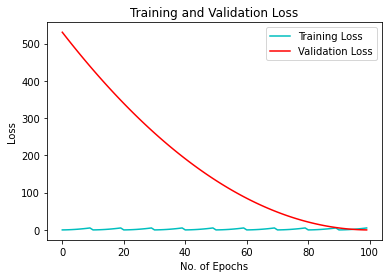

In [ ]:
for i in range(0,len(a_fns)):
  print("Activation Function: ", a_fns[i])
  nn=NeuralNetwork(4,[784, 256, 128, 64, 32, 10],0.1,a_fns[5],"normal",128,100)
  nn.fit(x_train,y_train,x_val,y_val)
  print("Training Accuracy:",nn.score(x_train,y_train))
  print("Testing Accuracy:",nn.score(x_test,y_test))
  nn.plots()


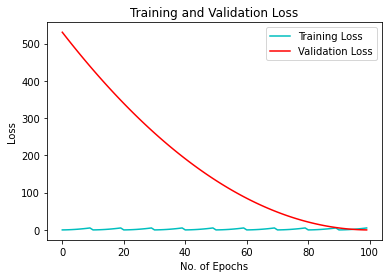

In [ ]:
nn.plots()